# Step 1: Import Libraries & Set Style

First, I'll import all the necessary libraries and set the default plot color to blue to keep our visuals consistent.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the default color palette for all plots to "Blues"
sns.set_palette("Blues_r") 
print("Libraries imported and style set to blue.")

Libraries imported and style set to blue.


# Step 2: Load and Prepare Data

Loading the `insurance.csv` file. I'll also create the `log_charges` column here, as my teammates did, since we'll need it for the plots.

In [2]:
df = pd.read_csv("insurance.csv")

# Create a log-transformed column (log(1+x)) for a more normal distribution
df['log_charges'] = np.log1p(df['charges'])

df.head()

,age,sex,bmi,children,smoker,region,charges,log_charges
0,19,female,27.900,0,yes,southwest,16884.92400,9.734236
1,18,male,33.770,1,no,southeast,1725.55230,7.453882
2,28,male,33.000,3,no,southeast,4449.46200,8.400763
3,33,male,22.705,0,no,northwest,21984.47061,9.998137
4,32,male,28.880,0,no,northwest,3866.85520,8.260455


## Step 3: Analyze Charges Distribution

As a first step, I'll plot a histogram of the original `charges` column. This shows it's heavily right-skewed, meaning most people have low charges, but a few have very high charges.

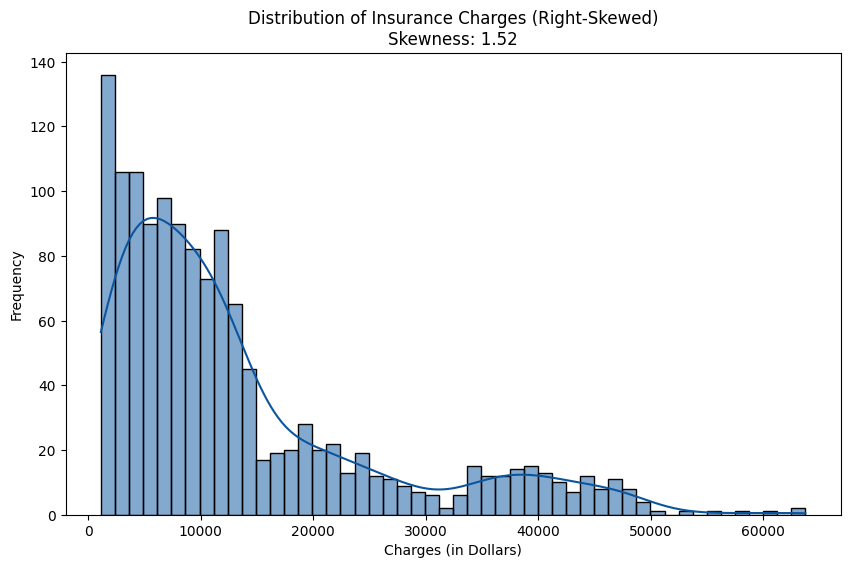

In [5]:
# Calculate skewness to confirm
original_skew = df['charges'].skew()

plt.figure(figsize=(10, 6))
sns.histplot(df['charges'], kde=True, bins=50)
plt.title(f'Distribution of Insurance Charges (Right-Skewed)\nSkewness: {original_skew:.2f}')
plt.xlabel('Charges (in Dollars)')
plt.ylabel('Frequency')
plt.show()

Now, here is the histogram of the `log_charges`. This distribution is much more symmetrical (less skewed), which is what the models in `final.ipynb` rely on.

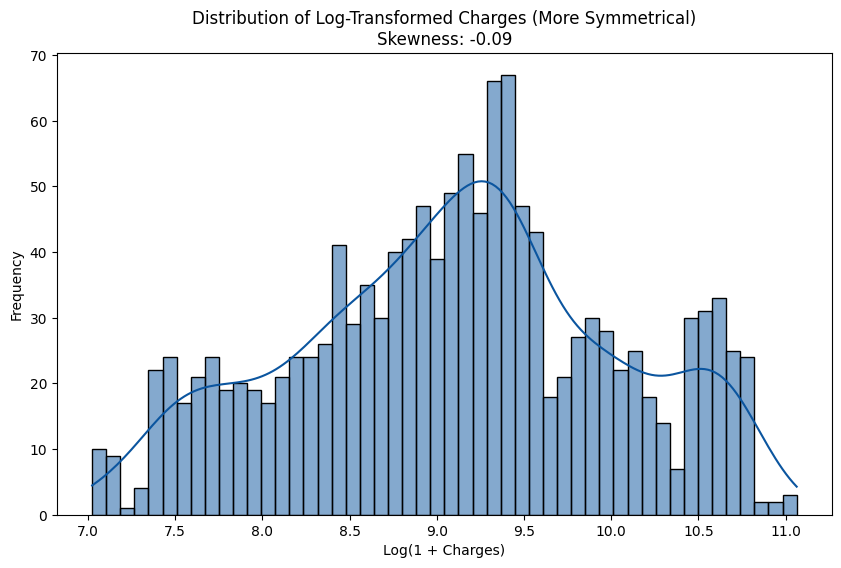

In [6]:
# Calculate skewness of the log-transformed data
log_skew = df['log_charges'].skew()

plt.figure(figsize=(10, 6))
sns.histplot(df['log_charges'], kde=True, bins=50) # It will be blue by default now
plt.title(f'Distribution of Log-Transformed Charges (More Symmetrical)\nSkewness: {log_skew:.2f}')
plt.xlabel('Log(1 + Charges)')
plt.ylabel('Frequency')
plt.show()

## Why We Are Predicting `log_charges` (Not `charges`)

Our initial EDA (the first histogram) clearly shows that our target variable, `charges`, is **heavily right-skewed**:
* The vast majority of insurance charges are low (under $15,000).
* There's a "long tail" of a few extremely high charges (outliers) that go over $60,000.

This skew is a problem for most models, including both Linear Regression and XGBoost.

### 1. For Linear Regression (LR)

Linear Regression assumes that the errors (or *residuals*) of the model are normally distributed (like a bell curve).
* **With Skew:** A model trained on skewed data will be heavily biased by the few high-value outliers. It will predict too high for most people and *way* too low for the expensive cases. This is why our first "Linear" model performed so poorly (R² of 0.083).
* **With Log-Transform:** The `log_charges` histogram is much more symmetrical. This helps the LR model meet its assumptions, leading to more reliable and accurate predictions.

### 2. For XGBoost (and other tree models)

While tree-based models like XGBoost aren't as strict about data assumptions, they *also* benefit hugely from a log-transformed target.
* **With Skew:** The model's error metric (RMSE) is very sensitive to large errors. The model will focus most of its effort on reducing a $10,000 error on a $50,000 charge, while ignoring a $1,000 error on a $2,000 charge.
* **With Log-Transform:** This effectively changes the problem. The model now tries to minimize the **percent error** instead of the *absolute dollar error*. This results in a more balanced and practically useful model that performs better on the *entire* range of data, not just the outliers.

### Our Strategy:

1.  **Transform:** We create a new target: `log_charges = np.log1p(df['charges'])`.
2.  **Train:** We train both our Linear Regression and XGBoost models to predict this `log_charges` value.
3.  **Invert:** When we get a prediction (which will be a log value), we convert it back to dollars using `np.expm1(prediction)` to get our final, interpretable answer.